In [1]:
import os
import random

import numpy as np
import pandas as pd

from skimage import io

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Pytorch
import torch, torchvision, torch.utils
from torch import Tensor
from torch import cat
from torch.autograd.grad_mode import no_grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss, BCELoss, CrossEntropyLoss, MSELoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)

import torch.nn.functional as F
from torchviz import make_dot
from torchsummary import summary
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,RocCurveDisplay,classification_report,precision_score,recall_score,f1_score
import time
from datasets import load_dataset

In [3]:
def matrix_confusion(yt, yp,time_taken):
    data = {'Y_Real': yt,
            'Y_Pred': yp}

    df = pd.DataFrame(data, columns=['Y_Real','Y_Pred'])
    confusion_matrix = pd.crosstab(df['Y_Real'], df['Y_Pred'], rownames=['Real'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True, fmt='g')

    plt.show()
    y_val = df['Y_Real'].to_numpy()
    predictions = df['Y_Pred'].to_numpy()
    accuracy = accuracy_score(y_val,predictions)
    precision = precision_score(y_val,predictions)
    recall = recall_score(y_val,predictions)
    f1 = f1_score(y_val,predictions)
    print('Time taken: ',time_taken)
    print('Test size:',len(y_val))
    print('Total Accuracy: ',accuracy)
    print('Total Precision: ',precision)
    print('Total Recall: ',recall)
    print('Total F1 Score: ',f1)
    print("Classification Report:\n")
    print(classification_report(y_val,predictions))


    return time_taken,accuracy,precision,recall,f1

In [4]:
torch.cuda.is_available()

True

In [5]:
 dataset = load_dataset('alkzar90/NIH-Chest-X-ray-dataset','image-classification')

Found cached dataset nih-chest-x-ray-dataset (C:/Users/rjuya/.cache/huggingface/datasets/alkzar90___nih-chest-x-ray-dataset/image-classification/1.0.0/9faae193f60780fddd036805dc6f9217cd59c258d08d71a7e4a2f2e2f99c8bbb)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256, interpolation=3),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),  # Convert to three-channel grayscale
    transforms.ToTensor(),
    transforms.Normalize([calculated_mean] * 3, [calculated_std] * 3),  # Normalize for three channels
])

In [6]:
train_loader = DataLoader(dataset['train'], shuffle=True, batch_size=4)
test_loader = DataLoader(dataset['test'], shuffle=True, batch_size=1)

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.PngImagePlugin.PngImageFile'>

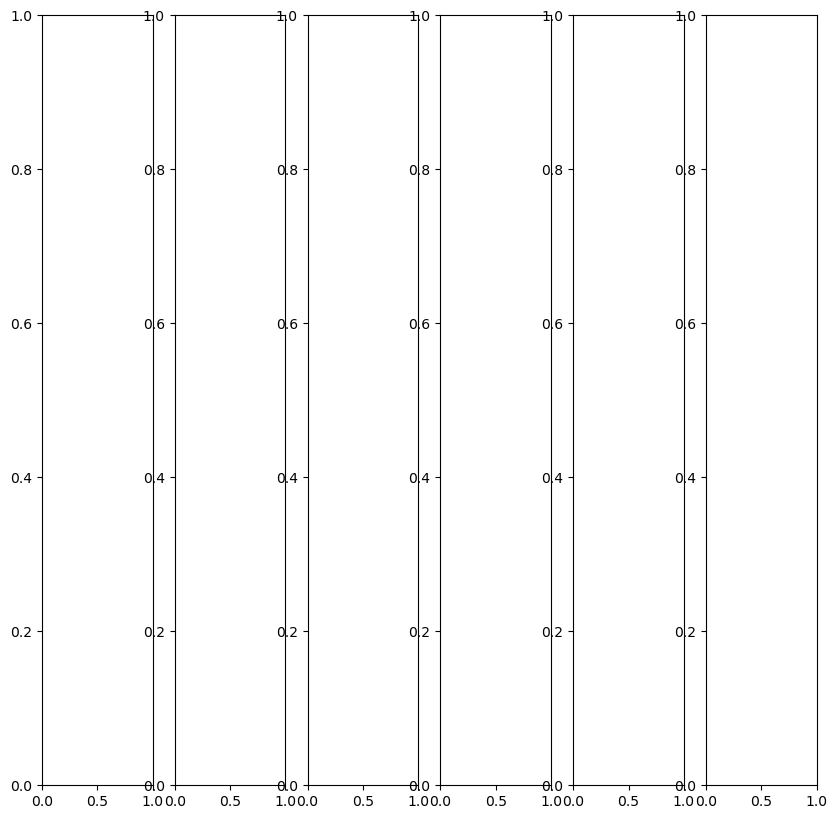

In [7]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 10))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap=plt.cm.rainbow)
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title(f"Labeled: {targets[0].item()}")

    n_samples_show -= 1

In [8]:
class Net2(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(3, 128, kernel_size=5)
        self.conv2 = Conv2d(128, 128, kernel_size=5)
        self.conv3 = Conv2d(128,128,kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(739328, 128)
        self.fc2 = Linear(128, 15)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2,2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2,2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return cat((x, 1 - x), -1)
    
model2 = Net2()

In [9]:
torch.cuda.empty_cache()

In [10]:
model = model2.to('cuda')

In [11]:
print(model)

Net2(
  (conv1): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=739328, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=15, bias=True)
)


In [12]:
summary(model, (3, 640, 640),  device='cuda')

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 128, 636, 636]       9,728
├─Conv2d: 1-2                            [-1, 128, 314, 314]       409,728
├─Conv2d: 1-3                            [-1, 128, 153, 153]       409,728
├─Dropout2d: 1-4                         [-1, 128, 76, 76]         --
├─Linear: 1-5                            [-1, 128]                 94,634,112
├─Linear: 1-6                            [-1, 15]                  1,935
Total params: 95,465,231
Trainable params: 95,465,231
Non-trainable params: 0
Total mult-adds (G): 53.95
Input size (MB): 4.69
Forward/backward pass size (MB): 514.16
Params size (MB): 364.17
Estimated Total Size (MB): 883.02


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 128, 636, 636]       9,728
├─Conv2d: 1-2                            [-1, 128, 314, 314]       409,728
├─Conv2d: 1-3                            [-1, 128, 153, 153]       409,728
├─Dropout2d: 1-4                         [-1, 128, 76, 76]         --
├─Linear: 1-5                            [-1, 128]                 94,634,112
├─Linear: 1-6                            [-1, 15]                  1,935
Total params: 95,465,231
Trainable params: 95,465,231
Non-trainable params: 0
Total mult-adds (G): 53.95
Input size (MB): 4.69
Forward/backward pass size (MB): 514.16
Params size (MB): 364.17
Estimated Total Size (MB): 883.02

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = CrossEntropyLoss().to('cuda')
testing_for_blast = 0
check_six_percent = 1
epochs = 16
model.train()
count = 1
loss_list = []
total_accuracy = []
model_path2 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/dataset2/CNNmodel.pt'
tic = time.time()
for epoch in range(epochs):
    correct = 0
    total_loss = []
    batch_size = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size+=1
        optimizer.zero_grad(set_to_none=True)
        output = model(data.to('cuda'))  # Forward pass, Data to GPU
        loss = loss_func(output, target.to('cuda')) #Labels to GPU
        loss.backward()  # Backward pass
        optimizer.step()
        total_loss.append(loss.item())
        train_pred = output.argmax(dim=1, keepdim=True)
        correct += train_pred.eq(target.to('cuda').view_as(train_pred)).sum().item()
    loss_list.append(sum(total_loss) / len(total_loss))
    accuracy = 100 * correct / 4077 # No. of training examples = 4077
    total_accuracy.append(accuracy)
    if ((100*(epoch+1))//epochs)//(count*10) >0 :
      count+=1
      print('Saving model with test loss of {:.3f}'.format(total_accuracy[-1]))
      torch.save(model.state_dict(), model_path2)
    print(f"Training [{100.0 * (epoch + 1) / epochs:.0f}%]\tLoss: {loss_list[-1]:.4f}\tAccuracy: {accuracy:.2f}%")
    if check_six_percent == 0:
      check_six_percent=1
      print(f"Training [{100.0 * (epoch + 1) / epochs:.2f}%]\t Time Taken: {time.time()-tic:.2f} seconds")
      print('Saving model with test loss of {:.3f}'.format(total_accuracy[-1]))
      torch.save(model.state_dict(), model_path2)
    if testing_for_blast == 1:
      break

toc = time.time()

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.PngImagePlugin.PngImageFile'>

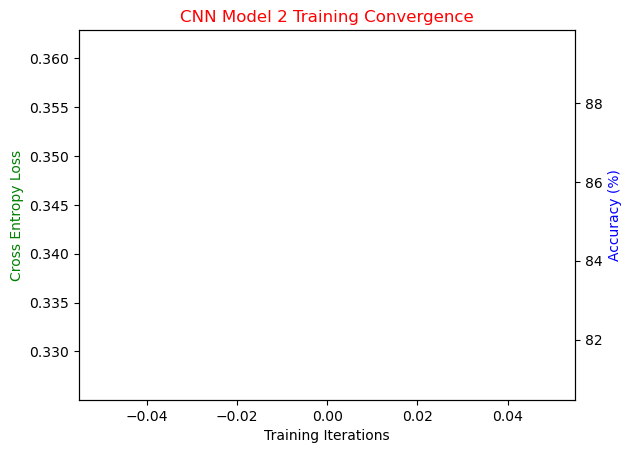

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(loss_list, 'g-')
ax2 = ax1.twinx()
ax2.plot(total_accuracy, 'b')
plt.title("CNN Model Training Convergence", color='red')
ax1.set_xlabel("Training Iterations")
ax1.set_ylabel("Cross Entropy Loss", color='g')
ax2.set_ylabel("Accuracy (%)", color='b')
plt.show()

In [ ]:
torch.save(model.state_dict(), model_path2)

In [ ]:
model_temp = Net2()
model_temp.load_state_dict(torch.load(model_path2))
model_temp= model_temp.to('cuda')

In [ ]:
batch_size=1

model_temp.eval()
pred_targets = []
test_targets= []
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_temp(data.to('cuda'))
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        pred_targets.append(pred.item())
        test_targets.append(target.item())
        correct += pred.eq(target.to('cuda').view_as(pred)).sum().item()

        loss = loss_func(output, target.to('cuda'))
        total_loss.append(loss.item())

    print(f"Performance on test data:\n\tLoss: {sum(total_loss) / len(total_loss):.4f}\n\tAccuracy: {100 * correct / len(test_loader) / batch_size:.2f}%")
    print(test_targets)
    print(pred_targets)

Performance on test data:
	Loss: 0.2003
	Accuracy: 94.42%
[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,

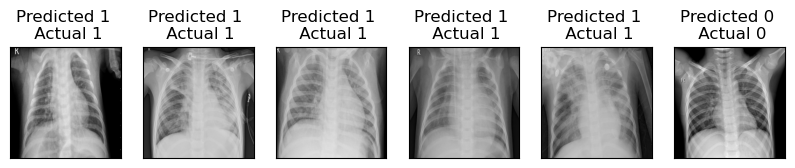

In [ ]:
from PIL import Image
#abc
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_temp.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model_temp(data.to('cuda')[0:1])
        if len(output.shape) == 1:
            output = output.reshape(3, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        test_targets2 = target.item()
        axes[count].imshow(torchvision.transforms.ToPILImage(mode='RGB')(data[0].squeeze()), cmap=plt.cm.rainbow)

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {} \n Actual {}".format(pred.item(),test_targets2))

        count += 1

In [ ]:
time_taken = toc-tic

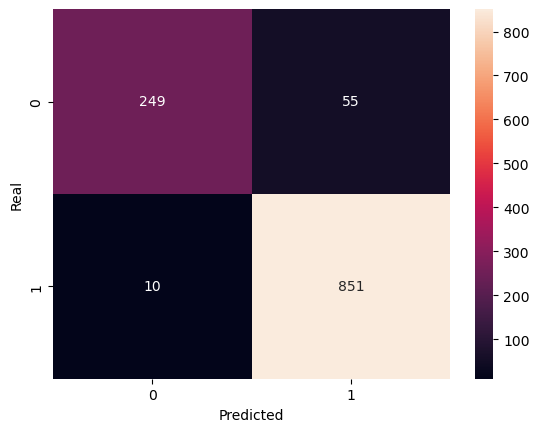

Time taken:  4485.35955119133
Test size: 1165
Total Accuracy:  0.944206008583691
Total Precision:  0.9392935982339956
Total Recall:  0.9883855981416957
Total F1 Score:  0.9632144878324844
Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.82      0.88       304
           1       0.94      0.99      0.96       861

    accuracy                           0.94      1165
   macro avg       0.95      0.90      0.92      1165
weighted avg       0.95      0.94      0.94      1165



In [ ]:
val_CNN2 = matrix_confusion(test_targets, pred_targets,time_taken)

In [ ]:
out2 = pd.DataFrame([val_CNN2],
                   index = ['CNN Model'],
                  columns=['Time','Accuracy','Precision','Recall','F1 score'])
out2.sort_values('Time')

,Time,Accuracy,Precision,Recall,F1 score
CNN Model 2,4485.359551,0.944206,0.939294,0.988386,0.963214


In [ ]:
import pickle

In [ ]:
filepath1 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/dataset2/CNNmodeloutput.pickle'
with open(filepath1, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(out2, file)
    print("Data Stored Successfully")

Data Stored Successfully
